In [1]:
import numpy as np
from utility import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os
import cv2
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/bzr0014/envs/AI/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['log', 'colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


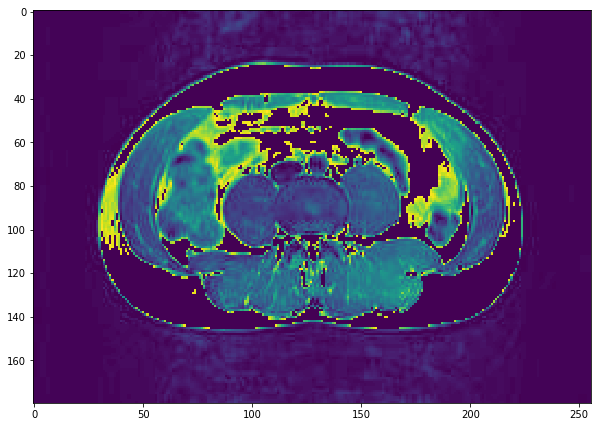

In [2]:
pylab.rcParams['figure.figsize'] = (10, 9)
original = cv2.imread('test_original.jpg', 0)
tmp1 = original < np.percentile(original, 85)
mid1 = original * tmp1
imshow(mid1)

(180, 256)


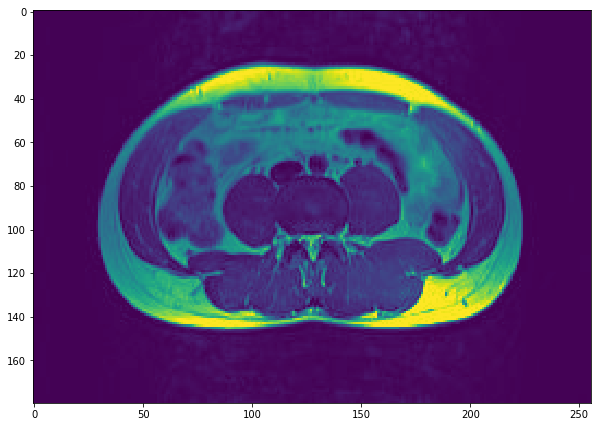

In [3]:
original = mpimg.imread('test_original.jpg').astype('float64')
print(original.shape)
imshow(original)

(6820,)


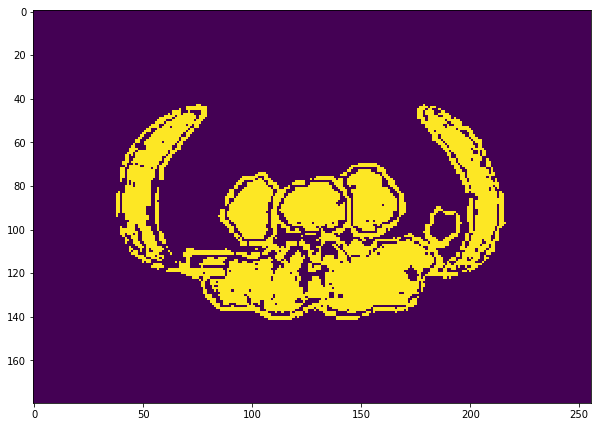

In [4]:
a = mpimg.imread('test_marked2.tif').astype('uint8')
imshow(a)
marks = (a[:, :, 0] > 157) * (a[:, :, 1] < 100)
plt.imshow(marks)
print(np.where(marks == 1)[0].shape)

In [5]:
neighSize = 21
w, h = original.shape
numNeighInRows = w - neighSize + 1
X = []
y = []
for i in range(w-neighSize+1):
    X_tmp = []
    y_tmp = []
    for j in range(h-neighSize+1):
        X_tmp.append(original[i:i+neighSize, j:j+neighSize])
        y_tmp.append(marks[i:i+neighSize, j:j+neighSize])
    X.append(X_tmp)
    y.append(y_tmp)
X = np.array(X) 
X = (X - X.mean())/X.std()
y = np.array(y) 
print(X.shape)
print(y.shape)
assert(X.shape == (w-neighSize+1, h-neighSize+1, neighSize, neighSize))
assert(X.shape == y.shape)

(160, 236, 21, 21)
(160, 236, 21, 21)


(181, 257)
(181, 257)


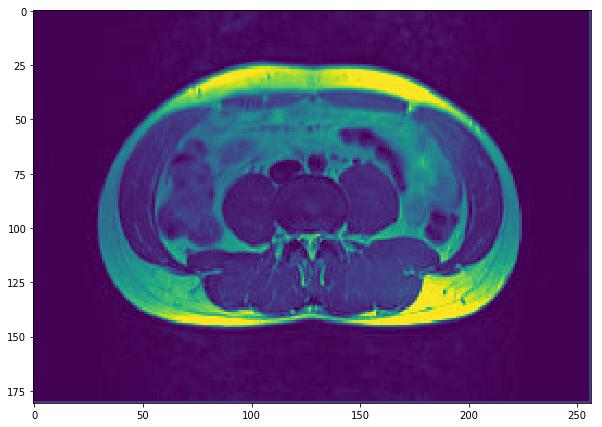

In [6]:
def reconstruct(y):
    a, b, c, d = y.shape
    reconstructed = np.zeros((a+c, b+d))
    for i in range(a):
        for j in range(b):
            reconstructed[i:i+neighSize, j:j+neighSize] = y[i, j]
    return reconstructed
y_reconstructed = reconstruct(y)
X_reconstructed = reconstruct(X)
print(y_reconstructed.shape)
print(X_reconstructed.shape)
assert(y_reconstructed.shape == X_reconstructed.shape)
imshow(X_reconstructed)

In [7]:
print(X.shape)
X_train = X.reshape(-1, neighSize, neighSize, 1)
y_train = y.reshape(-1, neighSize, neighSize)[:, neighSize//2, neighSize//2]
#numData = X_train.shape[0]
#train_size = int(numData * .8)
#X_val = X_train[train_size:]
#y_val = y_train[train_size:]
#X_train = X_train[:train_size]
#y_train = y_train[:train_size]

(160, 236, 21, 21)


In [8]:
print(X_train.shape)
print(y_train.shape)
#print(X_val.shape)
#print(y_val.shape)

(37760, 21, 21, 1)
(37760,)


In [9]:
tf.reset_default_graph()
X_tf = tf.placeholder(tf.float32, [None, neighSize, neighSize, 1])
y_tf = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)
layer_1_filter_size = 3
layer_1_filter_num = 20
layer_2_filter_size = 3
layer_2_filter_num = 20
layer_3_filter_size = 3
layer_3_filter_num = 30
output_shape = layer_3_filter_num * \
    (neighSize-layer_1_filter_size-layer_2_filter_size-layer_3_filter_size+3)**2
print("output shape:", output_shape)
def simple_model(X):
    Wconv1 = tf.get_variable("Wconv1", shape=[layer_1_filter_size, layer_1_filter_size, 1, layer_1_filter_num])
    bconv1 = tf.get_variable("bconv1", shape=[layer_1_filter_num])
    Wconv2 = tf.get_variable("Wconv2", shape=[layer_2_filter_size, layer_2_filter_size, \
                                              layer_1_filter_num, layer_2_filter_num])
    bconv3 = tf.get_variable("bconv3", shape=[layer_3_filter_num]) 
    Wconv3 = tf.get_variable("Wconv3", shape=[layer_3_filter_size, layer_3_filter_size, \
                                              layer_2_filter_num, layer_3_filter_num])
    bconv2 = tf.get_variable("bconv2", shape=[layer_2_filter_num])     
    W1 = tf.get_variable("W1", shape=[output_shape, 2])
    b1 = tf.get_variable("b1", shape=[2])
    
    # define our graph
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1, 1, 1, 1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    a2 = tf.nn.conv2d(h1, Wconv2, strides=[1, 1, 1, 1], padding='VALID') + bconv2
    h2 = tf.nn.relu(a2)
    a3 = tf.nn.conv2d(h2, Wconv3, strides=[1, 1, 1, 1], padding='VALID') + bconv3
    print(a3)
    h3_flat = tf.reshape(a3, [-1, output_shape])
    y_out = tf.matmul(h3_flat, W1) + b1
    return y_out

y_out = simple_model(X_tf)

total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y_tf, 2), logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

optimizer = tf.train.AdamOptimizer(5e-4)
#optimizer = tf.train.RMSPropOptimizer(5e-4)
train_step = optimizer.minimize(mean_loss)

output shape: 6750
Tensor("add_2:0", shape=(?, 15, 15, 30), dtype=float32)


In [117]:
checkpoint_path = './cnn1.ckpt'
checkpoint_file = '%s.data-00000-of-00001'%checkpoint_path

def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y_tf)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    print(Xd.shape)
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X_tf: Xd[idx,:],
                         y_tf: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.6g}"\
              .format(total_loss,total_correct,e+1))
        saver.save(session, checkpoint_path)
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

with tf.Session() as sess:
    if os.path.isfile(checkpoint_file):
        print('File Already Exists')
        saver.restore(sess, checkpoint_path)
    else:
        sess.run(tf.global_variables_initializer())
    print('Training')
    run_model(sess,y_out,mean_loss,X_train,y_train, epochs=50, batch_size=100,\
              print_every=100,training=train_step,plot_losses=False)
    #print('Validation')
    #run_model(sess,y_out,mean_loss,X_val,y_val,1,64)
    X_all = X.reshape(-1, neighSize, neighSize, 1)
    output = []
    for i in arange(0, X_all.shape[0], 100):
        output.append(y_out.eval(feed_dict={X_tf:X_all[i:i+100]}))
print("Done")

File Already Exists
INFO:tensorflow:Restoring parameters from ./cnn1.ckpt


TypeError: Cannot interpret feed_dict key as Tensor: The name 'init_and_save/save/Const:0' refers to a Tensor which does not exist. The operation, 'init_and_save/save/Const', does not exist in the graph.

In [10]:

layer_1_filter_size = 3
layer_1_filter_num = 20
layer_1_stride = 1
layer_2_filter_size = 5
layer_2_filter_num = 20
layer_2_stride = 1
layer_3_filter_num = 20
layer_3_filter_size = 7
layer_3_stride = 1
layer_3_dropout_rate = .25

n_fc1 = 128
fc1_dropout_rate = .5

n_outputs = 2
output_shape = layer_3_filter_num * \
    (neighSize-layer_1_filter_size-layer_2_filter_size-layer_3_filter_size+3)**2

tf.reset_default_graph()

print("output shape:", output_shape)

with tf.name_scope('inputs'):
    X_tf = tf.placeholder(tf.float32, [None, neighSize, neighSize, 1])
    y_tf = tf.placeholder(tf.int64, [None])
    punishment1 = tf.ones_like(y_tf)
    punishment2 = tf.ones_like(y_tf) * 10
    punishment = tf.cast(tf.where(y_tf == 0, punishment1, punishment2), tf.float32)
    training = tf.placeholder_with_default(False, shape=[], name='training')    
    
with tf.name_scope('convs'):
    conv1 = tf.layers.conv2d(X_tf, filters=layer_1_filter_num, kernel_size=layer_1_filter_size,\
                             strides=layer_1_stride, padding='SAME',\
                             activation=tf.nn.relu, name='conv1')
    conv2 = tf.layers.conv2d(X_tf, filters=layer_2_filter_num, kernel_size=layer_2_filter_size,\
                             strides=layer_2_stride, padding='SAME',\
                             activation=tf.nn.relu, name='conv2')
    conv3 = tf.layers.conv2d(X_tf, filters=layer_3_filter_num, kernel_size=layer_3_filter_size,\
                             strides=layer_3_stride, padding='SAME',\
                             activation=tf.nn.relu, name='conv3')   
with tf.name_scope('skip'):
    #skip = conv3 + X_tf
    skip = tf.concat([conv3, X_tf], axis=3)
    print(skip)
    skip_drop = tf.layers.dropout(skip, rate=layer_3_dropout_rate, training=training)
    skip_flat = tf.reshape(skip_drop, shape=[-1, neighSize*neighSize*(layer_3_filter_num+1)])

with tf.name_scope('fc1'):
    fc1 = tf.layers.dense(skip_flat, n_fc1, activation=tf.nn.relu, name='fc1')
    fc1_drop = tf.layers.dropout(fc1, rate=fc1_dropout_rate, training=training)

with tf.name_scope('output'):
    logits = tf.layers.dense(fc1_drop, n_outputs, name='output')
    y_prob = tf.nn.softmax(logits, name='y_prob')

with tf.name_scope('training'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y_tf)
    loss = tf.reduce_mean(xentropy)# * punishment)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y_tf, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
with tf.name_scope('init_and_save'):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

output shape: 1620
Tensor("skip/concat:0", shape=(?, 21, 21, 21), dtype=float32)


In [11]:
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)


In [12]:
n_epochs = 1000
batch_size = 100
train_indicies = np.arange(X_train.shape[0])

best_loss_val = np.infty
check_interval = 500
checks_since_last_progress = 0
max_checks_without_progress = 30
best_model_params = None 

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        np.random.shuffle(train_indicies)
        for iteration in range(int(math.ceil(X_train.shape[0]/batch_size))):
            start_idx = (iteration*batch_size)%X_train.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            X_batch = X_train[idx, :]
            y_batch = y_train[idx]
            sess.run(training_op, feed_dict={X_tf: X_batch, y_tf: y_batch, training: True})

        acc_train = accuracy.eval(feed_dict={X_tf: X_train, y_tf: y_train})
        #acc_test = accuracy.eval(feed_dict={X_tf: X_train, y_tf: y_train})
        loss_val = loss.eval(feed_dict={X_tf: X_train, y_tf: y_train})
        if loss_val < best_loss_val:
            best_loss_val = loss_val
            check_since_last_progress = 0
            best_model_params = get_model_params()
        else:
            checks_since_last_progress += 1       
        print(epoch, "Train accuracy:", acc_train, "loss:", loss_val)
        if checks_since_last_progress > max_checks_without_progress:
            print("Early stopping!")
            break
        save_path = saver.save(sess, "./my_trace_model")
        
    if best_model_params:
        restore_model_params(best_model_params)
    acc_test = accuracy.eval(feed_dict={X_tf: X_train, y_tf: y_train})
    print("Final accuracy on test set:", acc_test)
    save_path = saver.save(sess, "./my_mnist_model")

0 Train accuracy: 0.9156515 loss: 0.167471
1 Train accuracy: 0.9303496 loss: 0.14135623
2 Train accuracy: 0.93869174 loss: 0.12563324
3 Train accuracy: 0.94510067 loss: 0.115424305
4 Train accuracy: 0.95479345 loss: 0.10434587


KeyboardInterrupt: 

In [186]:
with tf.Session() as sess:
    saver.restore(sess, './my_trace_model')
    X_all = X.reshape(-1, neighSize, neighSize, 1)
    output = []
    for i in arange(0, X_all.shape[0], 100):
        output.append(logits.eval(feed_dict={X_tf:X_all[i:i+100]}))
predicted = np.array(output[:-1]).reshape(-1, 2)
predicted = np.vstack((predicted, output[-1]))
predicted.shape
predicted = np.exp(predicted)
predicted = predicted[:, 1] / np.sum(predicted, axis=1)
print(predicted.shape)
print(predicted.min())
print(predicted.max())
predicted = (predicted.reshape(160, 236))

INFO:tensorflow:Restoring parameters from ./my_trace_model
(37760,)
0.0
1.0


/home/bzr0014/envs/AI/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


In [195]:
with tf.Session() as sess:
    saver.restore(sess, './my_trace_model')
    output = y_prob.eval(feed_dict={X_tf:X_train})
    print(output.shape)
    
predicted = output[:, 1] / np.sum(output, axis=1)
print(predicted.shape)
print(predicted.min())
print(predicted.max())
predicted = (predicted.reshape(160, 236))

INFO:tensorflow:Restoring parameters from ./my_trace_model
(37760, 2)
(37760,)
0.0
1.0


(160, 236)

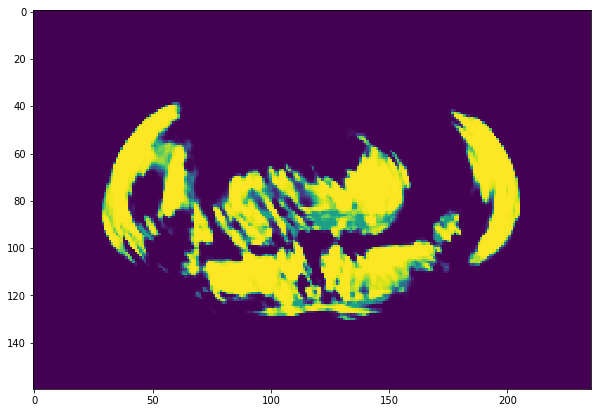

In [196]:
imshow(predicted)
predicted.shape

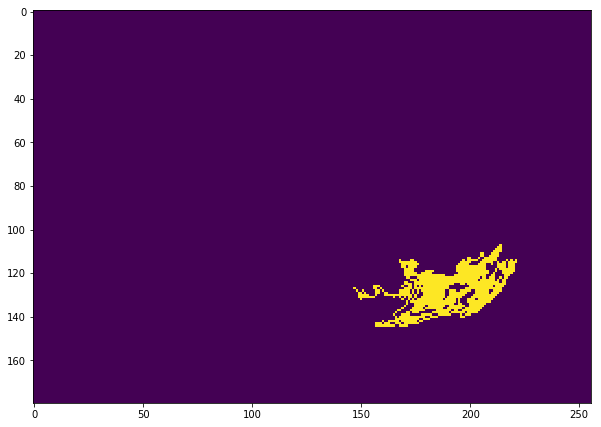

In [161]:
traces = np.zeros_like(original)
img = np.copy(original)
marked_pixels = np.where(marks > 0)
pix_index = np.random.randint(0, len(marked_pixels[0]))
i, j = np.array([marked_pixels[0][pix_index], marked_pixels[1][pix_index]])
for count in range(1000):
    traces[i, j] = 255
    neighbors = np.copy(img[i-1:i+2, j-1:j+2])
    trace_neighbors = np.copy(traces[i-1:i+2, j-1:j+2])
    neighbors[np.where(trace_neighbors == 255)] = -100
    im, jm = np.unravel_index(np.argmax(neighbors), neighbors.shape)
    i, j = (i+im-1, j+jm-1)
imshow(traces)